# PetFinder.my Adoption prediction
## Udacity Data Science nano-degree capstone project

### Project overview
The project was taken from a [kaggle competition](https://www.kaggle.com/c/petfinder-adoption-prediction).
To summarize the idea: We want to improve abandoned animals welfare (especially dogs/cats) by quicker adoption. 
PetFinder.my has been Malaysia’s leading animal welfare platform since 2008, with a database of more than 150,000 animals. 
Animal adoption rates are strongly correlated to the metadata associated with their online profiles, such as descriptive text and photo characteristics.
The beauty in the project is that it's well formulated, contains lots of various data types (thus allows to practice many aspects of the course) and is a real life problem.

### Problem Statement
Develop an alogrithm that ranks the adoptability of pets - specifically, **how quickly is a pet adopted**? 
This is a multiclass classification problem with 5 classes: (Although it can also be considered a regression problem)

* 0 - Pet was adopted on the same day as it was listed. 
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days). 

#### Strategy for solving the problem
In my mind and with the knowledge from this course and Coursera deep learning specialization.
1. Build upon previous works --> Scanning through [kaggle kernels](https://www.kaggle.com/c/petfinder-adoption-prediction/kernels) of the competition in order to understand the data and get an initial working direction.
2. Exploratory data analysis. 
3. Quick and dirty classification:
    * ETL pipeline for data.
    * Use some generic classifier with small params grid search. 
    * Analysis (metrics).
4. Write down list of ideas for improvement.
5. Start work iterations in the following manner:
   * Update ETL pipeline if required. 
   * Update classification. 
   * Analysis -> Test for improvement. 
6. Repeat until close to weighted kappa score of 0.3. (Around position 1500 in leader board, though I aspire for a score of 0.4, which should ) 

### Metrics
The competition metric is the **quadratic weighted kappa (qwk)**, which measures the agreement between two ratings.
I wasn't familiar with it prior to this exercise. A nice explanation can be found [here](https://stats.stackexchange.com/questions/248583/quadratic-weighted-kappa) or [here](https://en.wikipedia.org/wiki/Cohen%27s_kappa#Weighted_kappa). Why is it justified? Accuracy could have been a good metric because by definition we're interested in accurate predictions and we're not very afraid of FN or FP (Perhaps then we'd like to use precision/recall as metrics). The **qwk** is similar to accuracy but also attempts to consider the number of accurate predictions that were derived by **chance**. 


In [92]:
# Imports
import pandas as pd
import numpy as np
import json
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import nltk, gensim
import string
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import xgboost as xgb

# Cohen Kappa score metric exists in sklearn. See discussion here:
# https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps
from sklearn.metrics import cohen_kappa_score

# Set display options in Jupyter
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Exploration

In this section we'll explore the data a bit, get some insights about it, we begin with general statistics and data related to missing/unspecified values.

In [46]:
# Get data frame
filename = 'train.csv'
df = pd.read_csv(os.getcwd() + '\\Data\\' + filename)

# Show data example
df.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  Quantity  Fee  State                         RescuerID  VideoAmt                                        Description      PetID  PhotoAmt  AdoptionSpeed
0     2       Nibble    3     299       0       1       1       7       0             1          1           2         2           2       1         1  100  41326  8480853f516546f6cf33aa88cd76c379         0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0              2
1     2  No Name Yet    1     265       0       1       1       2       0             2          2           3         3           3       1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0  I just found it alone yesterday near my apartm...  6296e909a       2.0              0
2     1       Brisco    1     307       0       1       2       7       0             2          2           1         1           2       1         1    0  41326  fa90fa5b1ee11c86938398b60abc32cb         0  Their pregnant mother was dumped by her irresp...  3422e4906       7.0              3
3     1         Miko    4     307       0       2       1       2       0             2          1           1         1           2       1         1  150  41401  9238e4f44c71a75282e62f7136c6b240         0  Good guard dog, very alert, active, obedience ...  5842f1ff5       8.0              2
4     1       Hunter    1     307       0       1       1       0       0             2          1           2         2           2       1         1    0  41326  95481e953f8aed9ec3d16fc4509537e8         0  This handsome yet cute boy is up for adoption....  850a43f90       3.0              2

In [47]:
# Calcualte some statistics:
print('Total of %d listings in data and %d columns' % (df.shape[0], df.shape[1]))
print('Num of dogs: %d, (%2.2f%% of data)' % (df['Type'].value_counts()[1], 100*df['Type'].value_counts()[1]/df.shape[0]))
print('Num of cats: %d, (%2.2f%% of data)' % (df['Type'].value_counts()[2], 100*df['Type'].value_counts()[2]/df.shape[0]))
print('\nAdoption speeds distribution:\n%s\n' % (df['AdoptionSpeed'].value_counts()))

# How many animals per state?
index_list = df['State'].value_counts().index.tolist() # Create indices of states (StateID)
values_list = df['State'].value_counts().values.tolist() # How many animals per state
state_labels_df = pd.read_csv(os.getcwd() + '\\Data\\state_labels.csv') # Load the state labels data
states_dict = state_labels_df.set_index('StateID').to_dict()['StateName'] # Generate StateID<-->Name dictionary 
q = 0;
for state in index_list:
    print('State: %s, Animals: %d' % (states_dict[state], values_list[q]))
    q += 1

# Analyze missing values 
print('\nColumns with missing values (and how much):\n%s\n' % (df.isnull().sum()[df.isnull().sum() > 0]))

# For the the fields with "unsure/unknown"
print('Num of listings with UNSPECIFIED fur length: %d (%2.2f%%)' % 
      (df[df['FurLength'] == 0].shape[0], 100*df[df['FurLength'] == 0].shape[0]/df.shape[0]))
print('Num of listings with NOT SURE vaccination: %d (%2.2f%%)' % 
      (df[df['Vaccinated'] == 3].shape[0], 100*df[df['Vaccinated'] == 3].shape[0]/df.shape[0]))
print('Num of listings with NOT SURE dewormed: %d (%2.2f%%)' % 
      (df[df['Dewormed'] == 3].shape[0], 100*df[df['Dewormed'] == 3].shape[0]/df.shape[0]))
print('Num of listings with NOT SURE Sterilized: %d (%2.2f%%)' % 
      (df[df['Sterilized'] == 3].shape[0], 100*df[df['Sterilized'] == 3].shape[0]/df.shape[0]))
print('Num of listings with NOT Specified Health: %d (%2.2f%%)\n' % 
      (df[df['Health'] == 0].shape[0], 100*df[df['Health'] == 0].shape[0]/df.shape[0]))
    
# - How many have sentiments?
petIds = set(df['PetID'].values.tolist())
path = os.getcwd() + '\\Data\\train_sentiment'
filesList = os.listdir(path)
filesList = set( [word.split('.')[0] for word in filesList] )
num_no_listings = len(petIds) - len(petIds.intersection(filesList))
print('%d (%2.2f%%) have NO sentiment analysis\n' % (num_no_listings, 100*num_no_listings/df.shape[0]))

# How many have movies/photos?
num_listings_photo = df[df['PhotoAmt'] > 0].shape[0]
num_listings_video = df[df['VideoAmt'] > 0].shape[0]
print('%d (%2.2f%%) listings have photos' % (num_listings_photo, 100*num_listings_photo/df.shape[0]))
print('%d (%2.2f%%) listings have videos\n' % (num_listings_video, 100*num_listings_video/df.shape[0]))

# Check for duplicates
tmp = df.duplicated(subset=None, keep=False )
res = (tmp.head() == True).sum()
if (res == 0):
    print('NO DUPLICATES FOUND\n')
else:
    print('DUPLICATES FOUND\n')
    
# How many listings have more than one pet inside?
L = df[df['Quantity'] > 1].shape[0]
print('Listings with more than one pet: %d (%2.2f%%)' % (L, 100*L/df.shape[0]))

Total of 14993 listings in data and 24 columns
Num of dogs: 8132, (54.24% of data)
Num of cats: 6861, (45.76% of data)

Adoption speeds distribution:
4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64

State: Selangor, Animals: 8714
State: Kuala Lumpur, Animals: 3845
State: Pulau Pinang, Animals: 843
State: Johor, Animals: 507
State: Perak, Animals: 420
State: Negeri Sembilan, Animals: 253
State: Melaka, Animals: 137
State: Kedah, Animals: 110
State: Pahang, Animals: 85
State: Terengganu, Animals: 26
State: Sabah, Animals: 22
State: Kelantan, Animals: 15
State: Sarawak, Animals: 13
State: Labuan, Animals: 3

Columns with missing values (and how much):
Name           1257
Description      12
dtype: int64

Num of listings with UNSPECIFIED fur length: 0 (0.00%)
Num of listings with NOT SURE vaccination: 1868 (12.46%)
Num of listings with NOT SURE dewormed: 1781 (11.88%)
Num of listings with NOT SURE Sterilized: 1815 (12.11%)
Num of listings with NOT Specif

### Data Exploration (cnt.)
From the exploration above, we see that for the training data we have:
* Slight imbalance between dogs cats (approx. 45/55 split)
* Imbalanced labels, specifically, low number of pets adopted on the 1st day. ("Ideal scenario")
* Approximately 93% of pets in data are from 4 (out of 14) states in Malesia.
* Neglecting the name (which I don't think is relevant), there are only 12 missing descriptions. (negligble). 
* For about 12% of animals we're unsure about their vaccination/dewormed/sterlized status.
* Some listings (small fraction) don't have a Google sentiment analysis.
* Most listings have photos but only a fraction have videos.
* There are no duplicated values.
* A LOT of listings contain more than one pet!

So, to summarize, in terms of the ETL pipeline, the "abnormalities" we'll have to deal with are:
* Some columns which I don't see any use of (Name, RescuerID, ...) which I'll drop. 
* few missing descriptions. (Don't care about names).
* Some missing sentiments. 
* If photo raw data is required, some missing photos. 
* Imbalances in labels. (Will impact training). 
* Encoding categorical variable columns (such as color and breed). 
* Imbalances between number of dogs/cats in database (More on that later). 
* Imbalances between number of pets per state. 
* Listings with multiple pets. (Not sure yet how to approach this...)

**We now continue exploring relations between parameters and adoption speed (to get a feeling) regarding what will affect the adoption speed**

NOTE: according to the following [kernel](https://www.kaggle.com/conradws/don-t-put-cats-and-dogs-in-the-same-teapot) You can see that it's recommended to separate the dogs/cats classifications. This also follows my intuition, since (as a dog owner myself) I think people are looking for different things between dogs and cats. 

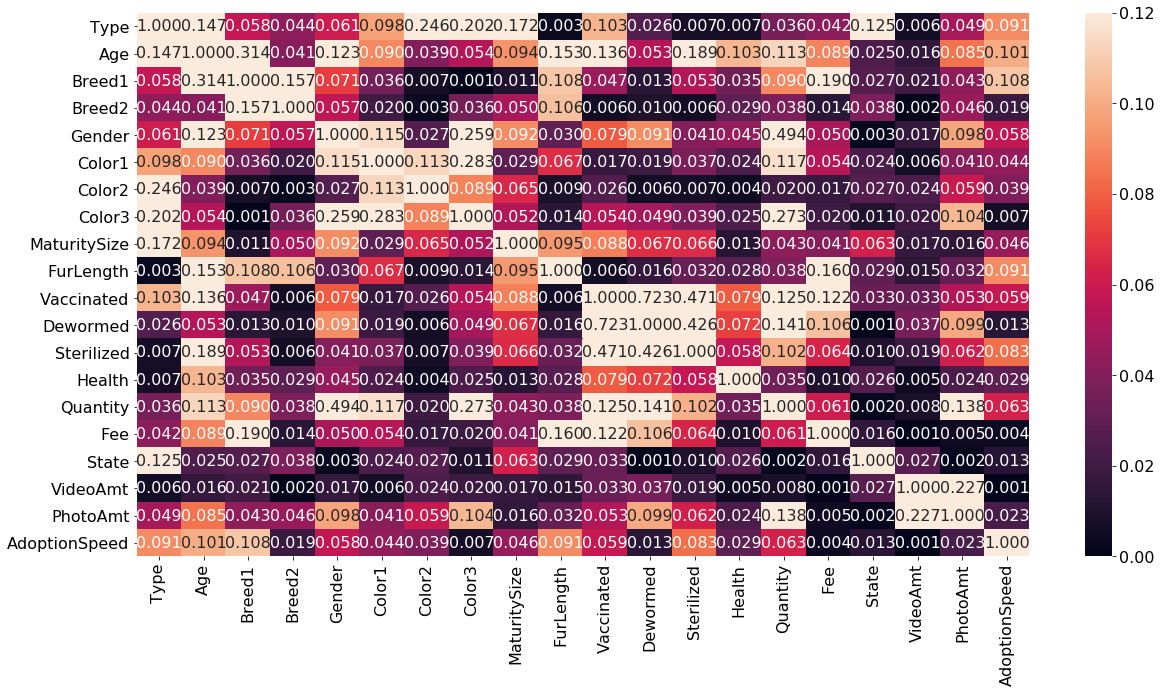

In [48]:
# First I want to examine the correlations in the data
fig, ax = plt.subplots(figsize=(20,10))  
sns.heatmap(np.abs(df.corr()), annot=True, fmt=".3f", ax=ax, vmin=0, vmax=0.12)

We observe some forseeable facts (vaccination/deworming and sterlization are all corellated, and also the fee. Makes sense. Money was spent on a "treated" pet so a fee is required. We can also see physical pet traits (Maturity size is related to gender. Probably males are bigger). However, all of this is nice. We want to focus on the Adoption speed correlation to the original columns. (Later we're going to add other columns...)

**NOTICE: Some correlations aren't very useful, because their categorical variables don't have any meaninfgul ordering. For example, Breed/Colors. The "higher" the "breed" goes, what's the impact on adoption speed? It's nonsense, so we need to disregard these fields.. Other fields have some ordinal meaning, for example, "Vaccinated: 1 = Yes, 2 = No, 3 = Not Sure", so, "higher value" means non vaccinated or "unsure" status. However, again, this is a rough approximation**

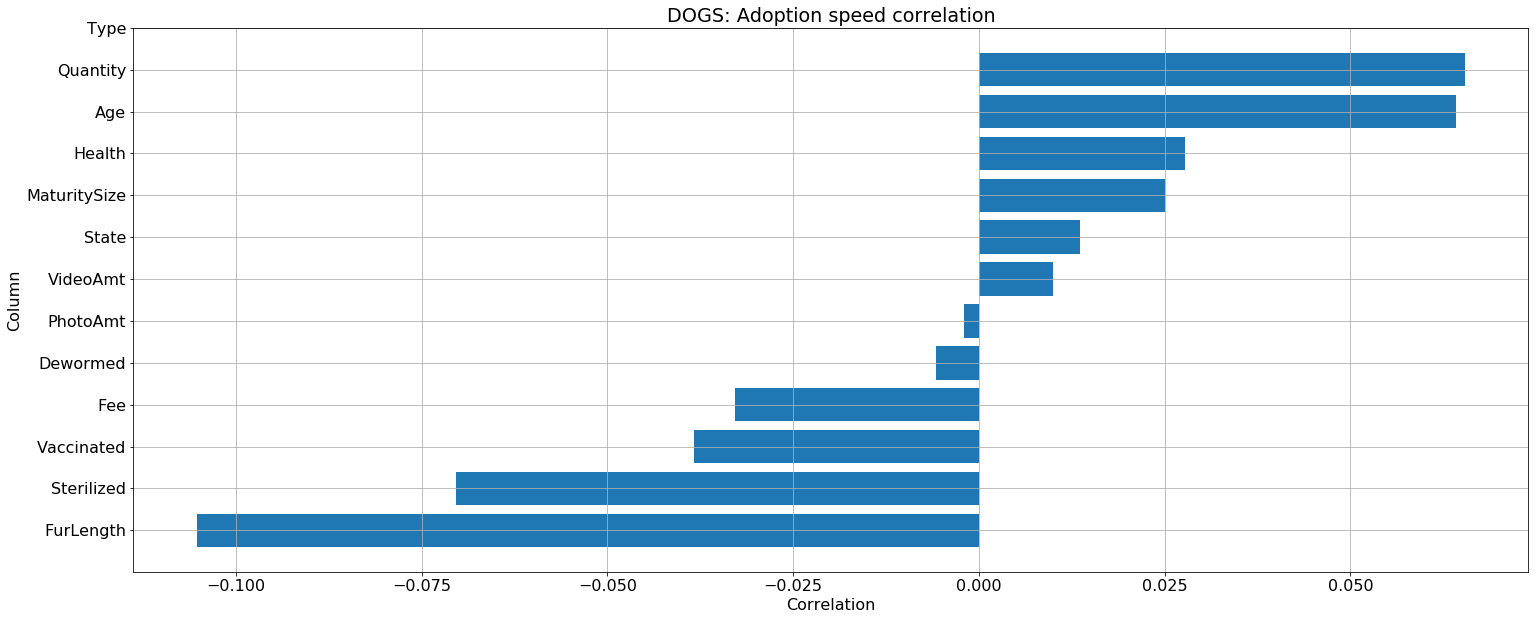

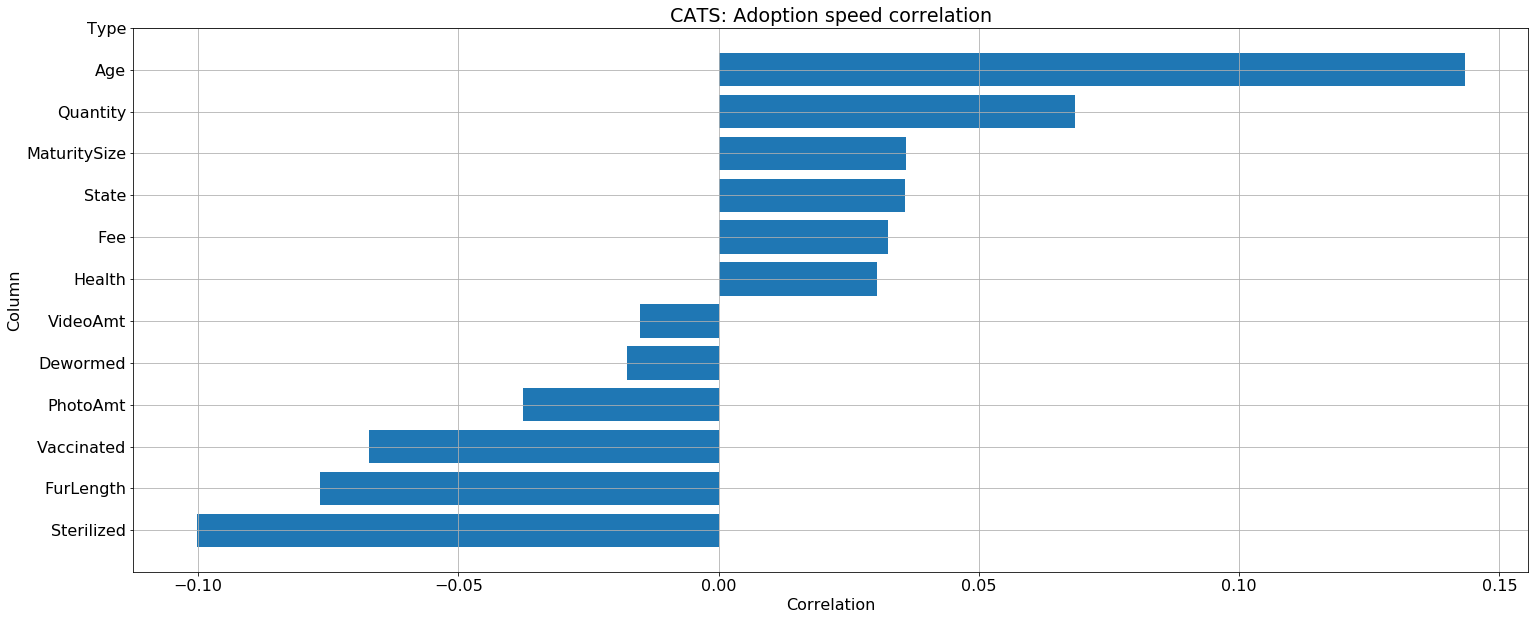

In [49]:
# Plot the Adoption speed correlation to other columns, seperating for dogs/cats
fontsize = 16
matplotlib.rcParams.update({'font.size': fontsize})
types = [1,2]
cols_to_remove = ['Breed1','Breed2','Color1','Color2','Color3', 'Gender']
tmp_df = df.drop(cols_to_remove, axis=1)
for petType in types:
    x = tmp_df[tmp_df['Type'] == petType].corr()['AdoptionSpeed'].sort_values().index.values.tolist()
    y = tmp_df[tmp_df['Type'] == petType].corr()['AdoptionSpeed'].sort_values().values.tolist()
    x.remove('AdoptionSpeed')
    y.remove(1.0)
    
    fig, ax = plt.subplots(figsize=(25,10)) 
    plt.barh(x,y)
    if petType == 1:
        plt.title('DOGS: Adoption speed correlation')
    else:
        plt.title('CATS: Adoption speed correlation')
    
    plt.grid(True)
    plt.xlabel('Correlation', fontsize = fontsize)
    plt.ylabel('Column',  fontsize = fontsize)   

### Analysis
We see 2 trends:
* 1st, dogs and cats behave DIFFERENTLY, regarding what "features" impact the adoption speed. This agrees with the kaggle kernel discussed previously.
* The most influencing ORIGINAL features (later, we'll generate more features) are:
  
  For dogs:
  * Age (Positive correlation. Older (higher value of age) dogs are waiting more for adoption)
  * Quantity (Positive correlation. The more dogs the longer it takes to adopt)
  * Fur length (Negative correlation. The more fur (higher value) the quicker (lower value) dogs get adopted). 
  * Sterilization (Negative correlation. The "higer" the value (not sterlized or unsure) the quicker dogs are adopted)
  
  For cats:
   * Same relations with age and quantity as dogs. 
   * Similar relations to dogs with sterilization and fur length, but for cats, sterilization (specifically, no sterlization) correlates more to faster adoption.
   
In general:
* It seems that the dominant features correlating to adoption speed are very similar between cats and dogs, even though the correlation values are different. 
* It seems that the **amount** of photos/videos isn't strongly related to adoption speeds which is good. I think that later on, adding a NN that extracts feature images might help, that is to say, I believe the **content** of the images may help.
* As an example, I'll also plot the "distribution" of adoption speed vs. fur length. We expect to see lower adoption values for higher fur values.

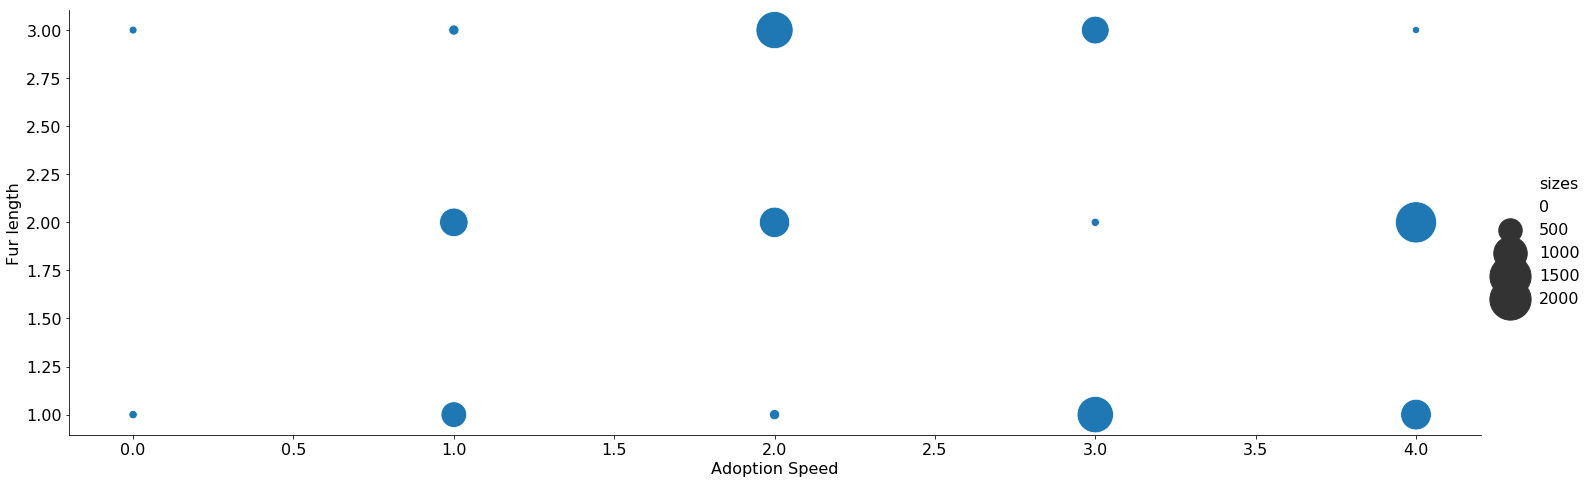

In [50]:
## Show "distribution" of adoption speeds vs fur length

# Init
sizes, furlen, adspeed = [], [1,2,3], [0,1,2,3,4]
x = adspeed * len(furlen) # Trick to generate a meshgrid 
y = furlen * len(adspeed) # Trick to generate a meshgrid

# Extract data for dogs
tmp = df[df['Type'] == 1][['FurLength','AdoptionSpeed']]

# Count how many values in each group. Probably there's a better "Pandas" way to do it
for f in furlen:
    tmp2 = tmp[tmp['FurLength'] == f]
    for a in adspeed:
        tmp3 = tmp2[tmp2['AdoptionSpeed'] == a]
        sizes.append(tmp3.shape[0])
                
# Generate dataframe from meshgrid and sizes
tmp = pd.DataFrame({'Fur length':y, 'Adoption Speed':x, 'sizes': sizes})

# Plot
g = sns.relplot(y='Fur length',x='Adoption Speed', size='sizes', sizes=(0, 1700), palette="muted",data=tmp,
               aspect = 3, height = 7)

### Analysis
It's not that obvious, but we can see that there's a concentration of values in the lower right side (short fur, long time for adoption) and a concentration in the middle upper part (medium to long fur, shorter adoption times). This supports our earlier correlation findings.

**Summary: I can add many more plots, but I think these ones + the tabular data are sufficent to CONCISELY describe the relations between parameters and the data. The interested reader may see many more data explorations [here](https://www.kaggle.com/artgor/exploration-of-data-step-by-step)**.

## Processing
Here we'll start the first iteration of our processing (quick and dirty) stage. 
* I'll define a function that extracts a sentiment from the text description using the supplied data. 
* I'll define an ETL pipeline that will handle much of the issues I described at the beginning (columns to drop, remove null values, one hot encoding, etc.). 
* I'll define a quick and dirty classifier, not too much thought in it and examine its performance. 
* We'll do some initial analysis and start refinements. 

In [52]:
def OneHotEncodeDF(df):
    '''TODO: Write description for function here - Not the most efficient function but works'''

    ## Create dictionaries from files
    # Load files
    breed_labels_df = pd.read_csv(os.getcwd() + '\\Data\\breed_labels.csv')
    color_labels_df = pd.read_csv(os.getcwd() + '\\Data\\color_labels.csv')
    state_labels_df = pd.read_csv(os.getcwd() + '\\Data\\state_labels.csv')

    # Generate dictionaries from files
    breed1_dict = pd.Series('Breed1_' + breed_labels_df['BreedName'].values, 
                            index = breed_labels_df['BreedID']).to_dict()
    breed1_dict[0] = 'Breed1_nan'
    breed2_dict = pd.Series('Breed2_' + breed_labels_df['BreedName'].values, 
                            index = breed_labels_df['BreedID']).to_dict()
    breed2_dict[0] = 'Breed2_nan'
    color1_dict = pd.Series('Color1_' + color_labels_df['ColorName'].values,
                                  index = color_labels_df['ColorID']).to_dict()
    color2_dict = pd.Series('Color2_' + color_labels_df['ColorName'].values,
                                  index = color_labels_df['ColorID']).to_dict()
    color2_dict[0] = 'Color2_nan'
    color3_dict = pd.Series('Color3_' + color_labels_df['ColorName'].values,
                                  index = color_labels_df['ColorID']).to_dict()
    color3_dict[0] = 'Color3_nan'

    state_dict = pd.Series('State_' + state_labels_df['StateName'].values,
                                 index = state_labels_df['StateID']).to_dict()

    # Generate dictionaries manually https://www.kaggle.com/c/petfinder-adoption-prediction/data
    Gender_dict = {1: 'Gender_male', 2: 'Gender_female', 3: 'Gender_mixed'}
    MaturitySize_dict = {1: 'mSize_S', 2: 'mSize_M', 3: 'mSize_L', 4: 'mSize_XL', 0: 'mSize_nan'}
    FurLength_dict = {1: 'furLen_S', 2: 'furLen_M', 3: 'furLen_L', 0: 'furLen_nan'}
    Vaccinated_dict = {1: 'vaccinated_yes', 2: 'vaccinated_no', 3: 'vaccinated_nan'}
    Dewormed_dict = {1: 'dewormed_yes', 2: 'dewormed_no', 3: 'dewormed_nan'}
    Sterilized_dict = {1: 'sterilized_yes', 2: 'sterilized_no', 3: 'sterilized_nan'}
    Health_dict = {1: 'health_good', 2: 'health_minorInjury', 3: 'health_seriousInjury', 4: 'health_nan'}

    # Create dummy variables for all columns 
    breed1 = pd.get_dummies(df['Breed1'], prefix_sep='_')
    breed1.rename(columns=breed1_dict, inplace=True)

    breed2 = pd.get_dummies(df['Breed2'], prefix_sep='_')
    breed2.rename(columns=breed2_dict, inplace=True)

    color1 = pd.get_dummies(df['Color1'], prefix_sep='_')
    color1.rename(columns=color1_dict, inplace=True)

    color2 = pd.get_dummies(df['Color2'], prefix_sep='_')
    color2.rename(columns=color2_dict, inplace=True)

    color3 = pd.get_dummies(df['Color3'], prefix_sep='_')
    color3.rename(columns=color3_dict, inplace=True)

    state = pd.get_dummies(df['State'], prefix_sep='_')
    state.rename(columns=state_dict, inplace=True)

    Gender = pd.get_dummies(df['Gender'], prefix_sep='_')
    Gender.rename(columns=Gender_dict, inplace=True)
    MaturitySize = pd.get_dummies(df['MaturitySize'], prefix_sep='_')
    MaturitySize.rename(columns=MaturitySize_dict, inplace=True)
    FurLength = pd.get_dummies(df['FurLength'], prefix_sep='_')
    FurLength.rename(columns=FurLength_dict, inplace=True)
    Vaccinated = pd.get_dummies(df['Vaccinated'], prefix_sep='_')
    Vaccinated.rename(columns=Vaccinated_dict, inplace=True)
    Dewormed = pd.get_dummies(df['Dewormed'], prefix_sep='_')
    Dewormed.rename(columns=Dewormed_dict, inplace=True)
    Sterilized = pd.get_dummies(df['Sterilized'], prefix_sep='_')
    Sterilized.rename(columns=Sterilized_dict, inplace=True)
    Health = pd.get_dummies(df['Health'], prefix_sep='_')
    Health.rename(columns=Health_dict, inplace=True)

    # Rebuild a new dataframe with the one-hot encodings
    new_df = pd.DataFrame(data=df[['Type','Age']], index=df.index.values) 
    new_df = pd.concat([new_df, breed1, breed2, Gender, color1, color2, color3, MaturitySize, FurLength,
                        Vaccinated, Dewormed, Sterilized, Health, df[['Quantity','Fee']], state, 
                        df[['VideoAmt','PetID', 'PhotoAmt','sentiment', 'AdoptionSpeed']]], axis=1)

    return new_df

In [53]:
# Utilize Google NLP sentiment analysis to get a "score" for the description. This score will be fed into
# the classifier/regressor
def GetDescriptionSentiment(filename):
    '''Gets the json filename and returns the sentiment as weighted average of all sentiments'''
    
    # Open and read file
    fullpath = os.getcwd() + '\\Data\\train_sentiment\\' + filename
    try:
        with open(fullpath, errors='ignore') as f:
            description = json.load(f)
    except:
        return 0
    
    # Collect all scores and magnitudes
    scores, magnitudes = [],[]
    for sentence in description['sentences']:
        scores.append(sentence['sentiment']['score'])
        magnitudes.append(sentence['sentiment']['magnitude'])
        
    # Weighted score is the weighted average of scores
    w_score = 0
    L = len(scores)
    for i in range(0,L):
        w_score += (scores[i] * magnitudes[i])/L
    
    return w_score

In [357]:
def ETL_pipeline(filename, is_test_set):

    # Init
    columns_to_drop = ['Name','RescuerID']
    do_additional_nlp = 0 # Set to 1 for running an NLP function
    DOG, CAT = 1,2

    ## Load the data
    df = pd.read_csv(os.getcwd() + '\\Data\\' + filename)

    ## Drop non relevant columns (in my opinion)
    df.drop(columns_to_drop, axis=1, inplace=True)

    ## Drop rows with missing values
    # ASSUMPTION: Negligble number of such rows.
    # Todo: According to train/test data, missing values only in description. Can be handled differently since description
    # is later replaced by sentiment or other embedding...
    indices_with_nan = df[pd.isnull(df).any(axis=1)].index.values
    df.drop(labels=indices_with_nan, inplace=True)

    ## No normalization / scaling since classifier isn't going to be distance based (no Neural Network)
    
    ## No duplicates handling (I checked on train/test data)

    ## Replace description with sentiment
    sentiments = []
    for rowIdx in range(0,df.shape[0]):
        sentiments.append(GetDescriptionSentiment(df.iloc[rowIdx]['PetID']+'.json'))

    # Concatenate the sentiments to our dataframe, then drop the
    sentiments_df = pd.DataFrame({'sentiment':sentiments}, index=df.index.values)
    df = pd.concat([df, sentiments_df], axis=1, join='outer')
    if (do_additional_nlp==0):
        df.drop(labels=['Description'], inplace=True, axis=1)

    # One hot encoding for categorical variables (write function? Don't forget to drop them)
    # df = OneHotEncodeDF(df)
    
    # Finished all preparations, remove petID column
    # df.drop('PetID', axis=1, inplace=True)
    
    # Split to dogs/cats data frames
    df_dogs = df[df['Type'] == DOG]
    df_dogs = df_dogs.drop('Type', axis=1) # No longer need this column
    df_cats = df[df['Type'] == CAT]
    df_cats = df_cats.drop('Type', axis=1) # No longer need this column
    
    ## Generate dataframe for labels
    if (is_test_set == 0):
        labels_dogs = pd.DataFrame(df_dogs['AdoptionSpeed'], columns=['AdoptionSpeed']) # This is a dataframe
        df_dogs.drop('AdoptionSpeed', axis=1, inplace=True)
        labels_cats = pd.DataFrame(df_cats['AdoptionSpeed'], columns=['AdoptionSpeed']) # This is a dataframe
        df_cats.drop('AdoptionSpeed', axis=1, inplace=True)
    else:
        labels_dogs, labels_cats = [],[]

    return df_dogs, df_cats, labels_dogs, labels_cats

df_dogs, df_cats, labels_dogs, labels_cats = ETL_pipeline('train.csv',0)

In [55]:
def PlotEstimatorPerformance(clf, n_folds):
    train_scores, test_scores = [], []
    for foldIdx in range(0,n_folds):
        train_str = 'split'+str(foldIdx)+'_train_score'
        test_str = 'split'+str(foldIdx)+'_test_score'
        train_scores.append(clf.cv_results_[train_str][0])
        test_scores.append(clf.cv_results_[test_str][0])

    fig, ax = plt.subplots(figsize=(10,5))
    x = list(range(0,n_folds))
    plt.plot(x,train_scores, 'b-o', linewidth = 2, markerSize = 14)
    plt.plot(x,test_scores, 'r-o', linewidth = 2, markerSize = 14)
    plt.grid(True)
    plt.xlabel('Fold index')
    plt.ylabel('QWK score')
    plt.legend(['Training set','CV set'])
    plt.title('Mean Train QWK: %2.5f, Mean CV QWK: %2.5f' % (np.mean(train_scores), np.mean(test_scores)))

In [56]:
from sklearn.model_selection import learning_curve
# We define a function to plot the learning curve to get an estimate about the status of our estimator. 
# The function was copied from the scikit tutorials:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), 
                        scorer = make_scorer(cohen_kappa_score, weights='quadratic')):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt 

In [340]:
# Define parameters: NOTICE: Actually here, I already performed a grid search and the parameters written here are
# the ones giving the best results, so 
def FindBestXGBClfGridSearch(parameters, X_train, y_train, scorer, cv):
    # Initialize classifier
    xgb_model = XGBClassifier(verbosity = 3)

    # Initialize grid search with 5 folds
    clf = GridSearchCV(xgb_model, param_grid=parameters, scoring = scorer, cv=cv, 
                       verbose=True, return_train_score=True)

    # Train
    clf.fit(X_train, y_train)

    return clf

In [358]:
# Test results
def TestClassifier(clf, X, y, X_test, y_test, cv=5):
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    PlotEstimatorPerformance(clf, cv)
    y_pred = clf.predict(X_test)
    print('#### Test set cohen_kappa: %2.5f ####' % (cohen_kappa_score(y_test, y_pred, weights='quadratic')))
   # plot_learning_curve(clf.best_estimator_, 'XGBoost Learning curve', X, y, ylim=None, cv=5,
   #                     n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

In [189]:
# Parameters for grid search
# NOTE: In order for the tester not to waste time, I won't use these parameters, but actually the already 
# optimized ones
parameters = {'nthread':[6], #when use hyperthread, xgboost may become slower
              'objective':['multi:softmax'],
              'eta': [0.01, 0.05, 0.1], 
              'max_depth': [6,11],
              'min_child_weight': [5,11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.8],
              'missing':[-999],
              'seed': [42,24], 
              'num_boost_round': [20000], 
              'early_stopping_rounds': [100], 
              'num_class': [5]}
scorer =  make_scorer(cohen_kappa_score, weights='quadratic')
cv = 5

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.4s finished


Best parameters set found on development set:
{'colsample_bytree': 0.8, 'early_stopping_rounds': 100, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'nthread': 6, 'num_boost_round': 20000, 'num_class': 5, 'objective': 'multi:softmax', 'seed': 24, 'silent': 1, 'subsample': 0.8}
#### Test set cohen_kappa: 0.39887 ####


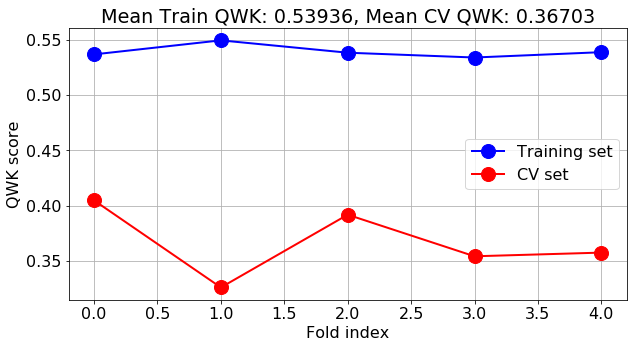

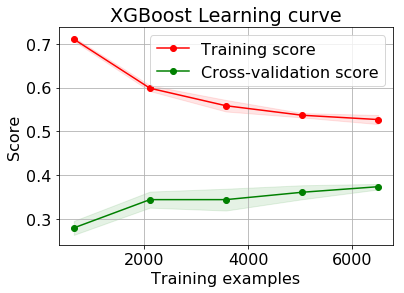

In [60]:
#------ DOGS classifier ---- #
# Best parameters we found for the dogs classifier
use_best_params = True
dogs_best_params = {'colsample_bytree': [0.8], 'early_stopping_rounds': [100], 'eta': [0.01], 'max_depth': [6], 
                    'min_child_weight': [11], 'missing': [-999], 'nthread': [6], 'num_boost_round': [20000], 
                    'num_class': [5], 'objective': ['multi:softmax'], 'seed': [24], 'silent': [1], 'subsample': [0.8]}

# Override parameters if needed
if use_best_params:
    parameters = dogs_best_params

# Start analysis with dogs
X = df_dogs.drop('PetID', axis=1)
y = labels_dogs['AdoptionSpeed']

# Split data to train/test sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

# Start with Extreme Gradient Boosting model (XGBoost)
# Reason is that most of best scoring classifiers used this model, so it's my starting point.
if use_best_params:
    dogs_clf = FindBestXGBClfGridSearch(dogs_best_params, X_train, y_train, scorer, cv)
else:        
    dogs_clf = FindBestXGBClfGridSearch(parameters, X_train, y_train, scorer, cv)

# Check performance of dogs classifier
TestClassifier(dogs_clf, X, y, X_test, y_test, cv)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.2s finished


Best parameters set found on development set:
{'colsample_bytree': 0.8, 'early_stopping_rounds': 100, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'nthread': 6, 'num_boost_round': 20000, 'num_class': 5, 'objective': 'multi:softmax', 'seed': 42, 'silent': 1, 'subsample': 0.8}
#### Test set cohen_kappa: 0.31979 ####


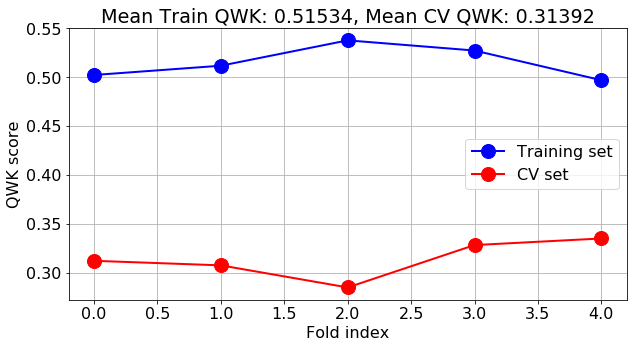

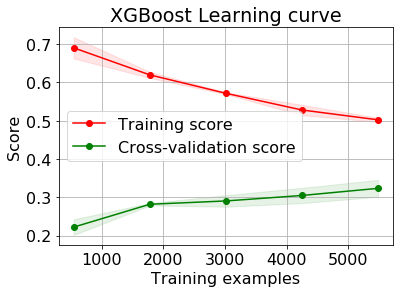

In [61]:
#------ Cats classifier ---- #
use_best_params = True
cats_best_params = {'colsample_bytree': [0.8], 'early_stopping_rounds': [100], 'eta': [0.01], 'max_depth': [6], 
                    'min_child_weight': [11], 'missing': [-999], 'nthread': [6], 'num_boost_round': [20000], 
                    'num_class': [5], 'objective': ['multi:softmax'], 'seed': [42], 'silent': [1], 'subsample': [0.8]}

# Start analysis with dogs
X = df_cats.drop('PetID', axis=1)
y = labels_cats['AdoptionSpeed']

# Split data to train/test sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

# Start with Extreme Gradient Boosting model (XGBoost)
# Reason is that most of best scoring classifiers used this model, so it's my starting point.
if use_best_params:
    cats_clf = FindBestXGBClfGridSearch(cats_best_params, X_train, y_train, scorer, cv)
else:        
    cats_clf = FindBestXGBClfGridSearch(parameters, X_train, y_train, scorer, cv)

# Check performance of dogs classifier
TestClassifier(cats_clf, X, y, X_test, y_test, cv)

In [62]:
# Save the models

### Background
1. Reminder (Ensemble methods): These methods can be divided to either bagging or boosting. Obviously, (by the name), we're talking about boosting. Short reminder: Boosting is a method that has multiple weak learners that are improved sequentially. Each learner cost function gets "punished" (increased weights) on the misclassified points of the previous learner and thus is "boosted". 

2. [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting): GBM wasn't learned in the current course. It's an ensemble method of boosting. In simple terms: 
    * Define $x$ the parameter we want to etimate.
    * at stage 'n', our estimator is a function of 'x', e.g. $F_n(x)=y_{estimated}$.
    * Ideally, we would like to have an $h(x)$ function such that $F_{n+1}(x)=y_{true}=F_n(x)+h(x)$
    * In other words: $h(x)=y_{true}-F_n(x)$
    * Notice that if we have a squared error loss $0.5(y-F_n(x))^2$, $h(x)$ is the gradient!

Therefore, gradient boosting will fit $h$ to the residual $y-F_n(x)$, and by "fitting" I mean it will try to find an approximation that will minimize the average value of the loss function on the training set. (An approximation can be some curve for a polynomial regression problem, for example).  

3. [XGBoost](https://arxiv.org/pdf/1603.02754.pdf) is an "extreme" version of Gradient Boosting. It can run over parallel processors and even on parallel machines (such as clusters in the cloud...).
   
### Analysis   
* I created 2 initial XGBoost models. One for cats and one for dogs. Their performance differs.
  It seems that the dog classifer is much better than the cat classifier, but both are OK for our first step.
  
* It was very important for me to plot the learning curves. From them, We notice 2 trends:
  * Training QWK reduces (Error is increased) the more samples we have. 
  * CV QWK increasing (Error is reduced) the more samples we have. 

Though it's not a "clear cut" case, It conclude that our model suffers from overfitting! Unfortunately, we don't have more training samples to add, but we can do other things.

### Refinement steps:
Now begins the fun stuff. We have extra data we didn't utilize and it might be MORE CORRELATED to the "quickness of adoption" that the data we used so far. We can extract some data from the description using NLP and we can extract features from the pictures using a deep NN. 

However, because it seems that more training samples might help, I wanted to test the impact of using the **COMBINED** samples of both dogs and cats, even though it seems that these two groups should be separated.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.9s finished


Best parameters set found on development set:
{'colsample_bytree': 0.8, 'early_stopping_rounds': 100, 'eta': 0.01, 'max_depth': 11, 'min_child_weight': 5, 'missing': -999, 'nthread': 6, 'num_boost_round': 20000, 'num_class': 5, 'objective': 'multi:softmax', 'seed': 42, 'silent': 1, 'subsample': 0.8}
#### Test set cohen_kappa: 0.35307 ####


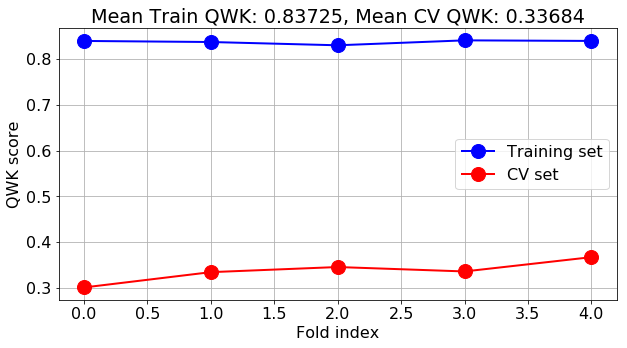

In [359]:
# We saved the best parameters we found earlier... 
use_best_params = True
combined_best_params = {'colsample_bytree': [0.8], 'early_stopping_rounds': [100], 'eta': [0.01], 'max_depth': [11], 
 'min_child_weight': [5], 'missing': [-999], 'nthread': [6], 'num_boost_round': [20000], 
 'num_class': [5], 'objective': ['multi:softmax'], 'seed': [42], 'silent': [1], 'subsample': [0.8]}

# Combine data
df_combined = pd.concat( [df_dogs, df_cats], axis = 0 )
labels_combined = pd.concat( [labels_dogs, labels_cats], axis = 0 )

# Start analysis with dogs
X = df_combined.drop('PetID', axis=1)
y = labels_combined['AdoptionSpeed']

# Split data to train/test sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

# Oversample
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Start with Extreme Gradient Boosting model (XGBoost)
# Reason is that most of best scoring classifiers used this model, so it's my starting point.
if use_best_params:
    combined_clf = FindBestXGBClfGridSearch(combined_best_params, X_train, y_train, scorer, cv)
else:        
    combined_clf = FindBestXGBClfGridSearch(parameters, X_train, y_train, scorer, cv)

# Check performance of dogs classifier
TestClassifier(combined_clf, X, y, X_test, y_test, cv)

### Results
I'll summarize the results in a table:

|Score|Dogs only | Cats only | Combined|
|-----|----------|-----------|---------|
|Train| 0.59323  | 0.57289   | 0.77606 |
|CV   | 0.36448  | 0.30739   | 0.34208 |

We see that the combined model is **slightly better** (cross validation) **than the average of both models**. This is counter my initial intuition, but the numbers don't lie. 
It seems as though the training performance will just keep deteriorating with more samples, which now points toward our model being more biased... To increase complexity I'll try to add some more features and see the impact.

But before that, let's just do a last check about the features importances and see if they're in agreement to the most correlated factors that infulence the adoption speed. 

In [ ]:
# Get the feature importances (sorted, from high to low)
sorted_importances = np.sort(combined_clf.best_estimator_.feature_importances_)[::-1]

# Get the feature importances INDICES (sorted, from high to low)
sorted_idxs = np.argsort(combined_clf.best_estimator_.feature_importances_)[::-1]

# Get the column names (minus the PetID which wasn't in the training/testing sets)
tmp = df_combined.drop('PetID', axis=1)

# Plot the first 50 most important features
fig, ax = plt.subplots(figsize=(20,20)) 
matplotlib.rcParams.fontsize = 16
N, fontsize = 50,20
yy = tmp.columns[sorted_idxs].tolist()[0:N]
xx = sorted_importances[0:N]
plt.barh(y[::-1],xx[::-1])
plt.title('Feature importance. Total variability: %2.2f' % (np.sum(xx)))
plt.grid(True)
plt.xlabel('Importance (between 0-1)', fontsize = fontsize)
plt.ylabel('Feature name',  fontsize = fontsize)   

### Feature importances
1. Even for 50 features we account for only ~50% of the model variability. This means that this is not a case where we have  few "Strong" predictors of adoption speed directly from the features, rather, it's more of a combination of all factors. 
2. Having said that, between all the features, seems that the following features are important:
    * "mixed breed"
    * "sterilization"
    * Hound or Collie breed type. 
    * State
    * Long fur. 
    * Age.
From the correlations, we expected the fur length, age and sterilization to impact, but failed to find a connection to the "mixed breed" or specific states. Even so, the contribution of these values is less than 10%. 

**Bottom line**: No strong "predictors", and in any case, I don't think we're overfitting here so also no need for dimensionality reduction such as PCA. One last attempt is observing the errors and attempting to find patterns:

In [68]:
# Some analysis of failed results for cats.. Can we see something interesting? 

# 1. The magnitude of errors distribution 
clf = combined_clf.best_estimator_
y_pred = clf.predict(X_test)
tmp = abs(y_pred-y_test)
num_errors = tmp[tmp.values > 0].shape[0]
err_list = (tmp[tmp.values > 0].value_counts().values/num_errors*100).tolist()
for i in range(1,5):
    print('%2.2f%% of prediction errors miss by %d' % (err_list[i-1], i))

##### We see that ~80% of errors miss prediction by 1 or 2 time units #####
research_df = df.loc[tmp[tmp.values > 3].index.values.tolist()]
research_df.head(50)

56.08% of prediction errors miss by 1
30.44% of prediction errors miss by 2
12.05% of prediction errors miss by 3
1.43% of prediction errors miss by 4


Type                               Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  Quantity  Fee  State                         RescuerID  VideoAmt                                        Description      PetID  PhotoAmt  AdoptionSpeed
260       1                            Wei Wei   14     307       0       1       2       0       0             3          2           1         1           1       1         1    0  41336  aa309eca97b65cd0a3d8bff4827e1905         0                           Very well taken care dog  e7e1904f4       3.0              0
5722      1                        â¥Billyâ¥   12     307       0       1       2       7       0             2          1           2         1           2       1         1    0  41326  8d413d99d41394f70d5c590253f80f54         0  ☆♥Billy☆♥ ☆♥Adopted By A Old Indian Lady From ...  2cf927db8       2.0              0
9804      1                               YUMI    5     307       0       2       1       2       7             2          2           1         1           2       1         1  150  41327  9153070cde2f487d2ab65e0bd114eb1d         1  YUMI is a approx 5 month old little angel, she...  86629a3ee       2.0              0
1972      2                             Mattie   12     266       0       2       1       7       0             2          1           1         1           1       1         1    0  41401  9b52af6d48a4521fd01d4028eb5879a3         0  I rescued Mattie with a broken leg. After surg...  1a8fd6707       5.0              0
14134     2                     Coco The Beach   24     265     288       1       1       5       7             3          2           3         3           3       1         1    0  41401  963ad390c9e109438686439b745b237c         0  this is coco, my lovely cat, coco is nice, coc...  9bd0992bc       4.0              0
13215     1                              Hiker    4     307       0       2       1       2       0             2          1           2         2           2       1         1    0  41326  25184a55b5ab6203e15df42feae46a11         0                    she is an active and lovely pup  aef6836e4       1.0              0
7550      2                               KyKy    6     266     299       2       6       7       0             1          1           2         2           1       1         1    0  41326  a70b02201c3b688f664fec4507aabe8c         0                                  Adopted at April/  9f3fe015b       1.0              0
13508     2                              Boboi    3     264     251       1       5       6       0             2          2           1         1           2       1         1  200  41326  021e427ea69bef958fb6222cb3eb0d4a         0  He's 3 moth and cute long hair... But he's mix...  769ad37c5       0.0              0
2354      2                               Noir    3     266       0       2       1       0       0             1          1           2         2           2       1         1    0  41326  45693d627ba33f56f4d228094fd4ae75         0  If you are interested in giving a home to thes...  8606e8738       2.0              0
1934      2                  Fiona,Snow & Baby   12     266     265       3       6       7       0             2          2           1         1           1       1         3    0  41401  deb62cfa84d7c48e9a396754a1e97ff0         0  Introducing my furkids (Fiona,Snow & Baby)!The...  dd5f7e678      10.0              0
2457      2                              Culat    3     266       0       2       1       2       4             1          1           1         1           2       1         1    0  41335  01324415629b56298d9756e3b6f8b2ba         0  Hi, My name is Culat. I was rescued by a kind ...  ac809f1ba       5.0              0
4699      1            Save ME Or I'll Die #45    2     307       0       3       1       2       0             2          1           3         3           3       2 

### Errors analysis
It seems that half the errors miss by one adoption speed unit.
The huge misses are usually for the ones adopted on the same day.
This probably happens because the training data is imbalanced and we don't have enough samples of this group. A correction can be to oversample this group, but for now, i'll move on.

### Adding features
We'll begin by attempting to extract more info from the description besides the Google sentiment analysis.

In [126]:
nltk.download('word2vec_sample')
nltk.download('stopwords')

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     C:\Users\sammykol\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sammykol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [99]:
word2vec_sample = str(nltk.data.find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)
df.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  Quantity  Fee  State                         RescuerID  VideoAmt                                        Description      PetID  PhotoAmt  AdoptionSpeed
0     2       Nibble    3     299       0       1       1       7       0             1          1           2         2           2       1         1  100  41326  8480853f516546f6cf33aa88cd76c379         0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0              2
1     2  No Name Yet    1     265       0       1       1       2       0             2          2           3         3           3       1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0  I just found it alone yesterday near my apartm...  6296e909a       2.0              0
2     1       Brisco    1     307       0       1       2       7       0             2          2           1         1           2       1         1    0  41326  fa90fa5b1ee11c86938398b60abc32cb         0  Their pregnant mother was dumped by her irresp...  3422e4906       7.0              3
3     1         Miko    4     307       0       2       1       2       0             2          1           1         1           2       1         1  150  41401  9238e4f44c71a75282e62f7136c6b240         0  Good guard dog, very alert, active, obedience ...  5842f1ff5       8.0              2
4     1       Hunter    1     307       0       1       1       0       0             2          1           2         2           2       1         1    0  41326  95481e953f8aed9ec3d16fc4509537e8         0  This handsome yet cute boy is up for adoption....  850a43f90       3.0              2

In [153]:
def EmbedDescription(description):
    # Initialize vector representation
    vec = np.zeros((300,))
        
    # Convert to lowercase (normalization)
    description = description.lower()
    
    # Remove punctuation
    description = description.translate(description.maketrans('', '', string.punctuation))
    
    # Split to words using tokenizer
    words = nltk.tokenize.word_tokenize( description )
    
    # Remove English stop words (assuming the text is in English)
    words = [w for w in words if w not in nltk.corpus.stopwords.words("english")]
    
    # Lemmatize form of words
    lemmed = set([WordNetLemmatizer().lemmatize(w) for w in words])
    
    # Leave only words of lemmed that are in our vocabulary
    in_vocab_lemmed = []
    for lem in lemmed:
        if lem in model.vocab:
            in_vocab_lemmed.append(lem)    
    
    # Get vector representation of each word
    l = len(in_vocab_lemmed)
    for word in in_vocab_lemmed:
        vec += model[word]/l
    
    return vec

In [182]:
N, q = df_combined.shape[0], 0
petIds = df_combined['PetID'].values.tolist()[0:N]

str_list = []
for idx in range(0, len(vec)):
    str_list.append('v_' + str(idx))
tmp_df = pd.DataFrame(columns = str_list)

for petID in petIds:
    
    # Print message
    if np.mod(q,100) == 0:
        print('Processed word embedding for %d descriptions of %d...' % (q, len(petIds)))
    
    # Get description
    description = df[df['PetID'] == petID]['Description'].values[0]
    
    # Get vector representation
    vec = EmbedDescription(description)
    
    # Add these features to our data
    tmp_df.loc[q] = vec
    q += 1

tmp_df.set_index(df_combined.index.values[0:N], inplace=True, verify_integrity=False)
tmp_df.head()


Processed word embedding for 0 descriptions of 14981...
Processed word embedding for 100 descriptions of 14981...
Processed word embedding for 200 descriptions of 14981...
Processed word embedding for 300 descriptions of 14981...
Processed word embedding for 400 descriptions of 14981...
Processed word embedding for 500 descriptions of 14981...
Processed word embedding for 600 descriptions of 14981...
Processed word embedding for 700 descriptions of 14981...
Processed word embedding for 800 descriptions of 14981...
Processed word embedding for 900 descriptions of 14981...
Processed word embedding for 1000 descriptions of 14981...
Processed word embedding for 1100 descriptions of 14981...
Processed word embedding for 1200 descriptions of 14981...
Processed word embedding for 1300 descriptions of 14981...
Processed word embedding for 1400 descriptions of 14981...
Processed word embedding for 1500 descriptions of 14981...
Processed word embedding for 1600 descriptions of 14981...
Processed

Processed word embedding for 13900 descriptions of 14981...
Processed word embedding for 14000 descriptions of 14981...
Processed word embedding for 14100 descriptions of 14981...
Processed word embedding for 14200 descriptions of 14981...
Processed word embedding for 14300 descriptions of 14981...
Processed word embedding for 14400 descriptions of 14981...
Processed word embedding for 14500 descriptions of 14981...
Processed word embedding for 14600 descriptions of 14981...
Processed word embedding for 14700 descriptions of 14981...
Processed word embedding for 14800 descriptions of 14981...
Processed word embedding for 14900 descriptions of 14981...


v_0       v_1       v_2       v_3       v_4       v_5       v_6       v_7       v_8       v_9      v_10      v_11      v_12      v_13      v_14      v_15      v_16      v_17      v_18      v_19      v_20      v_21      v_22      v_23      v_24      v_25      v_26      v_27      v_28      v_29      v_30      v_31      v_32      v_33      v_34      v_35      v_36      v_37      v_38      v_39      v_40      v_41      v_42      v_43      v_44      v_45      v_46      v_47      v_48      v_49      v_50      v_51      v_52      v_53      v_54      v_55      v_56      v_57      v_58      v_59      v_60      v_61      v_62      v_63      v_64      v_65      v_66      v_67      v_68      v_69      v_70      v_71      v_72      v_73      v_74      v_75      v_76      v_77      v_78      v_79      v_80      v_81      v_82      v_83      v_84      v_85      v_86      v_87      v_88      v_89      v_90      v_91      v_92      v_93      v_94      v_95      v_96      v_97      v_98  \
2  -0.002346  0.015736 -0.001158  0.022728 -0.014263  0.008234  0.035067 -0.033300  0.024232  0.028272  0.014849 -0.050390 -0.016774  0.002175 -0.034858  0.014900  0.013836  0.019384 -0.023783 -0.000595  0.013385  0.004167 -0.005741  0.017201  0.018708 -0.011920 -0.029603  0.030234  0.024912 -0.025837 -0.006505 -0.007724 -0.012877 -0.017999 -0.011498 -0.012687  0.027118 -0.012688 -0.009338  0.019556  0.024679 -0.019822  0.033315 -0.027438 -0.020164 -0.025794 -0.013009  0.027820  0.007551  0.025596 -0.008804  0.017098  0.011960 -0.003020  0.001605 -0.001405  0.003765 -0.024853  0.013633 -0.028712 -0.004972  0.006634 -0.023153 -0.022167 -0.004127  0.002153 -0.011675  0.022156 -0.017675  0.026379  0.031016  0.017992  0.003285  0.025164 -0.054235 -0.012442  0.016103  0.025117  0.027350  0.023214  0.027263  0.003175  0.004865  0.002466 -0.010206 -0.015538 -0.006436  0.024558  0.018450  0.002338  0.001548  0.014723 -0.022953 -0.026898 -0.011743 -0.022829  0.026402  0.006261 -0.005650   
3   0.017324  0.007305 -0.009623  0.025633 -0.013964  0.008616  0.030177 -0.027879  0.001304  0.016944  0.000108 -0.051374 -0.016487 -0.009585 -0.023406  0.030781  0.034126  0.039499 -0.013307 -0.027977  0.017153  0.020077 -0.004815  0.013377  0.025316  0.013988 -0.010126  0.008911  0.024287 -0.020063 -0.003867  0.009964 -0.024646 -0.021903  0.020718 -0.027186  0.032743 -0.005794  0.018292  0.028967  0.037600 -0.032097  0.017117 -0.005185 -0.018555 -0.034907 -0.024621 -0.014117 -0.006079  0.007279 -0.015138  0.018744  0.005466  0.013230  0.021122  0.026362  0.003070 -0.038983  0.022532 -0.031815 -0.017961  0.012815 -0.049120 -0.010288  0.016967  0.007460 -0.014511  0.005358 -0.046210  0.017465  0.033703  0.012552  0.023790  0.011266 -0.034894 -0.026354  0.032397  0.031359  0.033137  0.028798  0.005493  0.028418  0.036231  0.008071 -0.004837 -0.036682 -0.047095  0.013868  0.016740 -0.014763  0.012162 -0.002017 -0.016197 -0.009896 -0.004906 -0.021039  0.015757  0.002355 -0.016375   
4   0.020185  0.029460 -0.003240  0.031047 -0.022273  0.009519  0.050856 -0.023920  0.003048  0.030006  0.002147 -0.043150 -0.015714  0.005146 -0.032030  0.030596  0.005118  0.055671 -0.020625 -0.010330  0.000126  0.006259  0.040192  0.002584  0.008724 -0.020914 -0.035367  0.038622  0.038992 -0.020973 -0.005490  0.012960 -0.027714 -0.011990 -0.009406 -0.004990  0.050414 -0.007400  0.021668  0.038950  0.036525 -0.023607  0.045964 -0.002012  0.013355 -0.028534  0.000089  0.018409  0.007462  0.001241 -0.022753  0.019303 -0.002704  0.007393  0.023279  0.002844  0.002816 -0.023645 -0.007533 -0.000861 -0.008936  0.023427 -0.031672 -0.028819  0.005406  0.001295 -0.020229  0.031828 -0.017373  0.032926  0.039122  0.007633 -0.001811  0.018040 -0.052141  0.004678  0.007131  0.038024  0.044238  0.057564  0.024029  0.005767  0.012083 -0.010115 -0.030722  0.001802 -0.024719  0.026605  0.017584  0.009054  0.023611  0.028585 -0.037521 -0.044479 -0.009965 -0.042811  0.050604  0.023118 -0.018487   
7   0.035494  0.023471 -0

In [360]:
df_combined2 = pd.concat( [df_combined, tmp_df], axis=1)

# We saved the best parameters we found earlier... 
use_best_params = True
combined_best_params = {'colsample_bytree': [0.8], 'early_stopping_rounds': [100], 'eta': [0.01], 'max_depth': [6], 
 'min_child_weight': [11], 'missing': [-999], 'nthread': [6], 'num_boost_round': [20000], 
 'num_class': [5], 'objective': ['multi:softmax'], 'seed': [24], 'silent': [1], 'subsample': [0.8]}

# Start analysis with dogs
X = df_combined2.drop('PetID', axis=1)
y = labels_combined['AdoptionSpeed']

# Split data to train/test sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=11)

# Start with Extreme Gradient Boosting model (XGBoost)
# Reason is that most of best scoring classifiers used this model, so it's my starting point.
if use_best_params:
    combined_clf2 = FindBestXGBClfGridSearch(combined_best_params, X_train, y_train, scorer, cv)
else:        
    combined_clf2 = FindBestXGBClfGridSearch(parameters, X_train, y_train, scorer, cv)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished


Best parameters set found on development set:
{'colsample_bytree': 0.8, 'early_stopping_rounds': 100, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'nthread': 6, 'num_boost_round': 20000, 'num_class': 5, 'objective': 'multi:softmax', 'seed': 24, 'silent': 1, 'subsample': 0.8}
#### Test set cohen_kappa: 0.33619 ####


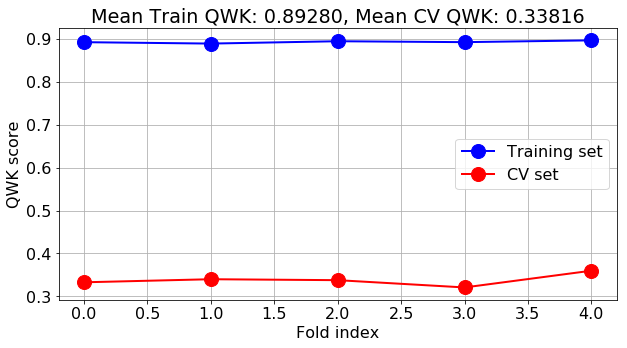

In [361]:
# Check performance of dogs classifier
TestClassifier(combined_clf2, X, y, X_test, y_test, cv)

### Results:
The conversion of the description into an embedded vector shows **MINOR** improvement on the CV QWK score, with a "heavy" price to pay in the term of overfitting the training data even more and adding a very large variable space. 
Before I attempt to add features extracted from the images, I'll first try to go the other way around and reduce features in order to get a simpler model.

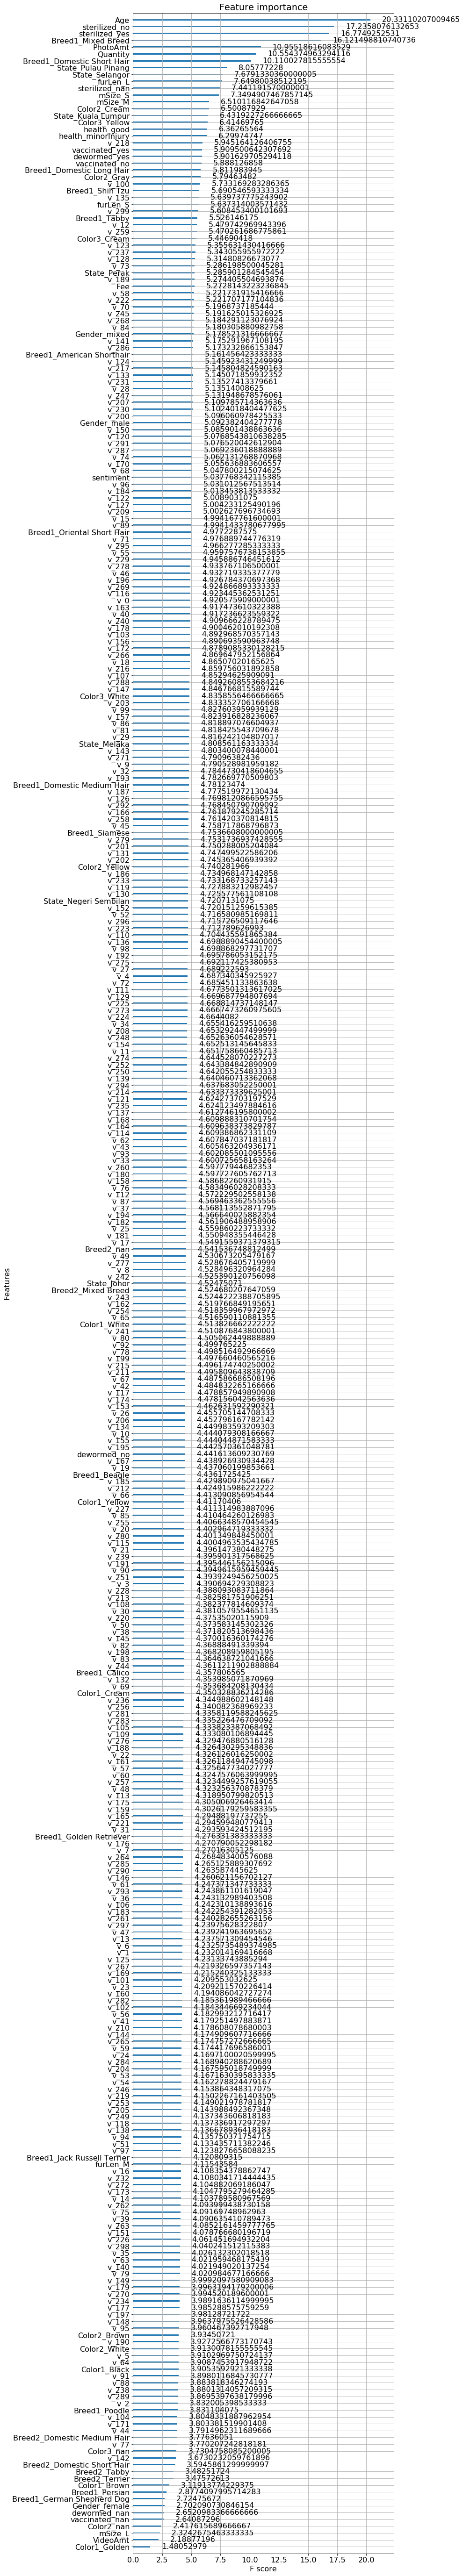

In [297]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,100)) 
matplotlib.rcParams.fontsize = 10
plot_importance(combined_clf2.best_estimator_, ax=ax, importance_type='gain')
#xgb.plot_tree(combined_clf2.best_estimator_)

In [347]:
# From the plot we see:
# Many zero features
# The embedded text has an important role in the importance for estimation.

# We saved the best parameters we found earlier... 
use_best_params = True
combined_best_params = {'colsample_bytree': [0.8], 'early_stopping_rounds': [10], 'eta': [0.01], 'max_depth': [11], 
 'min_child_weight': [20], 'missing': [-999], 'nthread': [6], 'num_boost_round': [20000], 
 'num_class': [5], 'objective': ['multi:softmax'], 'seed': [24], 'silent': [1], 'subsample': [0.8]}

idxs = np.where(combined_clf2.best_estimator_.feature_importances_ == 0)
colsList = np.array(df_combined2.columns.values.tolist())
df_combined3 = df_combined2.drop( columns = colsList[idxs], axis=1)

# Start analysis with dogs
X = df_combined3.drop('PetID', axis=1)
y = labels_combined['AdoptionSpeed']

# Split data to train/test sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=15)

# Start with Extreme Gradient Boosting model (XGBoost)
# Reason is that most of best scoring classifiers used this model, so it's my starting point.
if use_best_params:
    combined_clf3 = FindBestXGBClfGridSearch(combined_best_params, X_train, y_train, scorer, cv)
else:        
    combined_clf3 = FindBestXGBClfGridSearch(parameters, X_train, y_train, scorer, cv)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min finished


Best parameters set found on development set:
{'colsample_bytree': 0.8, 'early_stopping_rounds': 10, 'eta': 0.01, 'max_depth': 11, 'min_child_weight': 20, 'missing': -999, 'nthread': 6, 'num_boost_round': 20000, 'num_class': 5, 'objective': 'multi:softmax', 'seed': 24, 'silent': 1, 'subsample': 0.8}
#### Test set cohen_kappa: 0.34725 ####


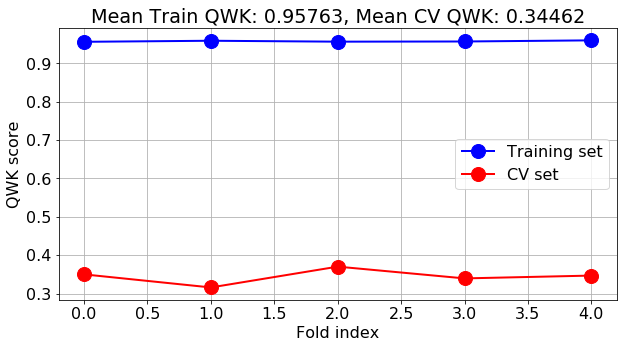

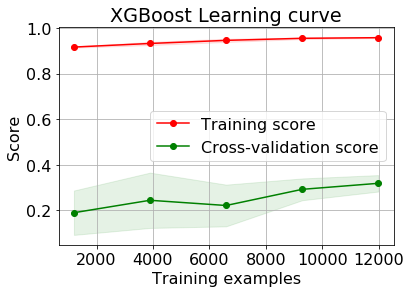

In [350]:
# Check performance of dogs classifier
TestClassifier(combined_clf3, X, y, X_test, y_test, cv)

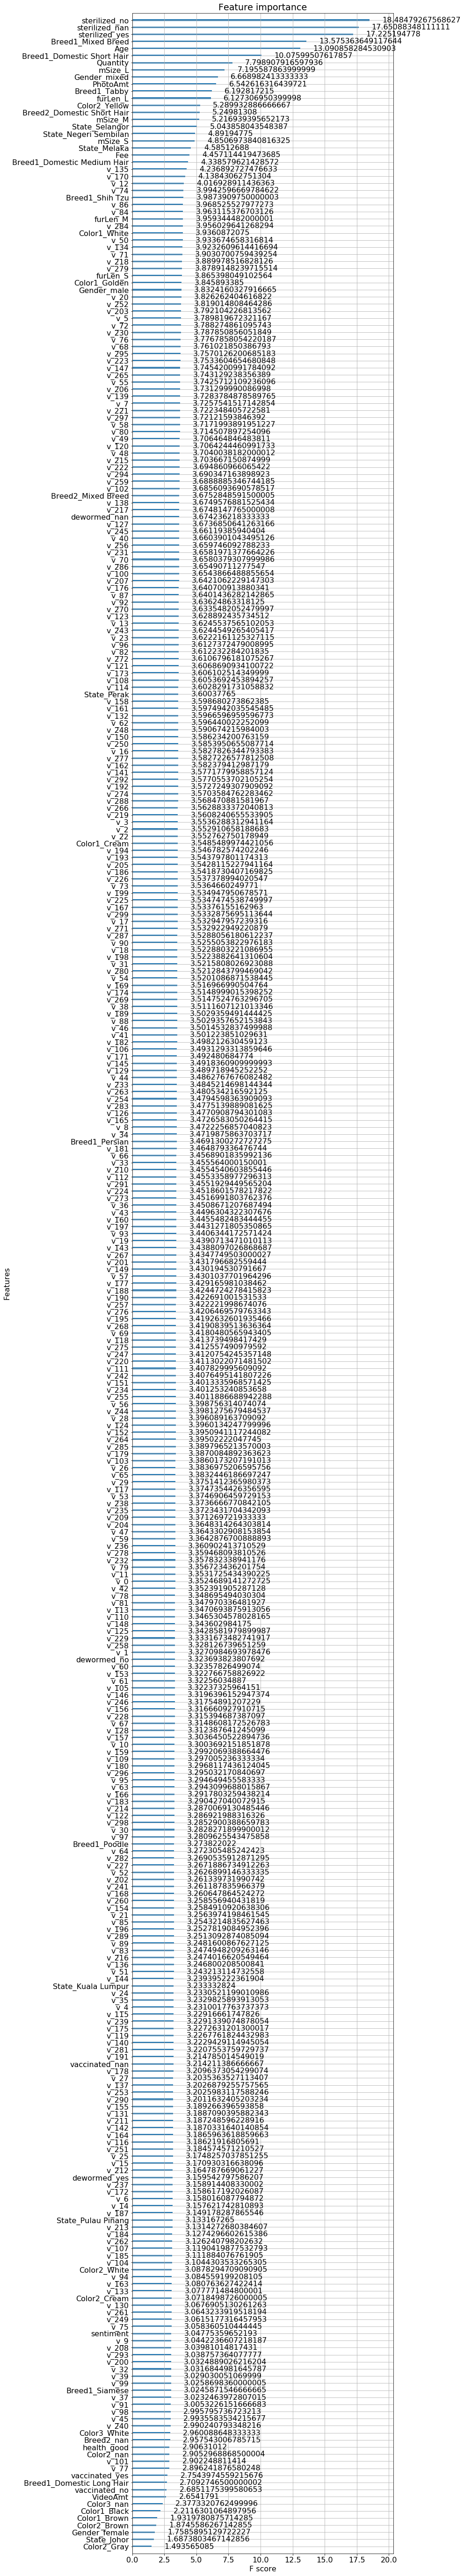

In [352]:
## Plot the feature importances again, see if they're consistent with our previous findings
fig, ax = plt.subplots(figsize=(10,100)) 
matplotlib.rcParams.fontsize = 10
plot_importance(combined_clf3.best_estimator_, ax=ax, importance_type='gain')
#xgb.plot_tree(combined_clf2.best_estimator_)

### Current refinments analysis
The QWK CV of our "decreased" model gives us (up to a negligble difference) the same performance. (0.34462 now vs. 0.34497 with the full model). However, we decreased the number of features that enter into the model by almost 40%, which leads to faster training times and a "simpler" model. However, we observe in an interesting effect. 
After changing the model, the importances also changed! These means the feature importance score we're using isn't totally dependable, because, a feature that was seen as important in the current model, is suddenly less important in a new model.
I read [here](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) about the issue. 

In any case, still, the meaning of Gain is the average training loss reduction gained when using a feature for splitting, so we just need to remember that the importances we see are per our **current** model, and not necessarily the actual real life importances. 

I will continue with this "refined" dataset and attempt to add features from the 1st image, if exists. 

In [356]:
df_combined3.shape

(14981, 372)